In [2]:
import pandas as pd 
from pandas import DataFrame
from pandas import concat
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as pyplot 
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
from pandas import read_csv

In [3]:
# Load dataset by using Pandas library 
dataset = pd.read_csv(r"E:\PhD study\ELEG5491 Introduction to Deep Learning\bitcoin\datasets\bitcoinwithgoogleandfin.csv", header=0, index_col=0)
values = dataset.values
print(dataset)
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# Here is created input columns which are (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# Here is created output/forecast column which are (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


                 Open       High        Low      Close        Volume  \
Date                                                                   
2014-10-20    389.231    390.084    378.252    382.845  1.641900e+07   
2014-10-21    382.421    392.646    380.834    386.475  1.418890e+07   
2014-10-22    386.118    388.576    382.249    383.158  1.164130e+07   
2014-10-23    382.962    385.048    356.447    358.417  2.645690e+07   
2014-10-24    358.591    364.345    353.305    358.345  1.558570e+07   
...               ...        ...        ...        ...           ...   
2021-03-28  55974.941  56610.312  55071.113  55950.746  4.768658e+10   
2021-03-29  55947.898  58342.098  55139.340  57750.199  5.762559e+10   
2021-03-30  57750.133  59447.223  57251.551  58917.691  5.441412e+10   
2021-03-31  58930.277  59930.027  57726.418  58918.832  6.552083e+10   
2021-04-01  58926.562  59586.070  58505.277  59095.809  6.166916e+10   

                  rsi  bitcoin  blockchain  buy bitcoin  sell b

In [4]:
# Dataset values are normalized by using MinMax method
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
print(len(scaled))


2356


In [5]:
# Normalized values are converted for supervised learning 
reframed = series_to_supervised(scaled,1,1,True)

# Dataset is splitted into two groups which are train and test sets
values = reframed.values 
train_size = int(len(values)*0.60)
validation_size = int(len(values)*0.80)
train = values[:train_size,:]
validation =values[(train_size+1):validation_size,:]
test = values[validation_size:,:]
print(train)
print(test)

[[0.00347836 0.00290136 0.00349635 ... 0.02056581 0.01292326 0.0134    ]
 [0.0033668  0.00294304 0.00354002 ... 0.01725522 0.01112002 0.        ]
 [0.00342737 0.00287683 0.00356395 ... 0.00792536 0.00240433 0.        ]
 ...
 [0.11248995 0.11161088 0.11268542 ... 0.25561798 0.03346023 0.01      ]
 [0.11134668 0.11135841 0.11413086 ... 0.22542135 0.04167502 0.0464    ]
 [0.11250715 0.11436986 0.11612458 ... 0.23404896 0.06832298 0.0464    ]]
[[0.11064792 0.10984399 0.10851305 ... 0.20626003 0.05780405 0.07      ]
 [0.10600183 0.1157151  0.10770256 ... 0.14125201 0.03115608 0.0175    ]
 [0.11632047 0.11606677 0.11618093 ... 0.16773676 0.05219395 0.0371    ]
 ...
 [0.91361617 0.94563772 0.92959717 ... 0.39586677 0.13043478 0.14      ]
 [0.94313959 0.96361538 0.96531816 ... 0.34470305 0.13283911 0.13      ]
 [0.9624722  0.97146941 0.97334895 ... 0.49839486 0.12262072 0.165     ]]


In [6]:
# Splitted datasets are splitted to trainX, trainY, testX and testY 
trainX, trainY = train[:,:-1], train[:,13]
validationX, validationY = validation[:,:-1], validation[:,13]
testX, testY = test[:,:-1], test[:,13]
print(trainY, trainY.shape)


[0.0034123  0.00335798 0.00295282 ... 0.11233078 0.11488003 0.11618143] (1413,)


In [7]:
# Train and Test datasets are reshaped to be used in LSTM
trainX = trainX.reshape((trainX.shape[0],1,trainX.shape[1]))
validationX = validationX.reshape((validationX.shape[0],1,validationX.shape[1]))
testX = testX.reshape((testX.shape[0],1,testX.shape[1]))
print(trainX.shape, trainY.shape,testX.shape,testY.shape)


(1413, 1, 19) (1413,) (471, 1, 19) (471,)


In [8]:
# LSTM model is created and adjusted neuron structure
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.01))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# Dataset is trained by using trainX and trainY, validated by validationX and validationY
history = model.fit(trainX, trainY, epochs=30, batch_size=25, validation_data=(validationX, validationY), verbose=2, shuffle=False)


Epoch 1/30
57/57 - 0s - loss: 2.3454e-04 - val_loss: 0.0010
Epoch 2/30
57/57 - 0s - loss: 6.2322e-04 - val_loss: 0.0014
Epoch 3/30
57/57 - 0s - loss: 7.0518e-04 - val_loss: 0.0014
Epoch 4/30
57/57 - 0s - loss: 0.0011 - val_loss: 8.1811e-04
Epoch 5/30
57/57 - 0s - loss: 8.1429e-04 - val_loss: 0.0021
Epoch 6/30
57/57 - 0s - loss: 2.8538e-04 - val_loss: 6.2960e-04
Epoch 7/30
57/57 - 0s - loss: 1.4638e-04 - val_loss: 3.9817e-04
Epoch 8/30
57/57 - 0s - loss: 1.2796e-04 - val_loss: 3.2748e-04
Epoch 9/30
57/57 - 0s - loss: 1.1463e-04 - val_loss: 2.6377e-04
Epoch 10/30
57/57 - 0s - loss: 9.9874e-05 - val_loss: 2.0800e-04
Epoch 11/30
57/57 - 0s - loss: 8.9577e-05 - val_loss: 1.5861e-04
Epoch 12/30
57/57 - 0s - loss: 7.6500e-05 - val_loss: 1.2453e-04
Epoch 13/30
57/57 - 0s - loss: 6.5446e-05 - val_loss: 9.9712e-05
Epoch 14/30
57/57 - 0s - loss: 6.1408e-05 - val_loss: 7.8272e-05
Epoch 15/30
57/57 - 0s - loss: 5.7400e-05 - val_loss: 6.6480e-05
Epoch 16/30
57/57 - 0s - loss: 5.7577e-05 - val_loss: 

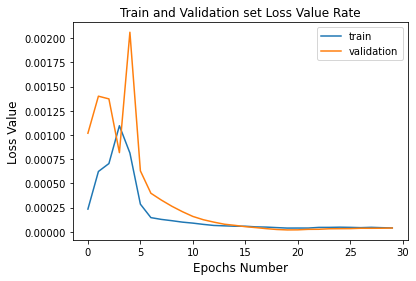

In [9]:
# Loss values are calculated for every training epoch and are visualized
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.title("Train and Validation set Loss Value Rate")
pyplot.xlabel('Epochs Number', fontsize=12)
pyplot.ylabel('Loss Value', fontsize=12)
pyplot.legend()
pyplot.show()

In [10]:
# Prediction process is performed for train dataset
trainPredict = model.predict(trainX)
trainX = trainX.reshape((trainX.shape[0], trainX.shape[2]))

# Prediction process is performed for validation dataset
validationPredict = model.predict(validationX)
validationX = validationX.reshape((validationX.shape[0], validationX.shape[2]))

# Prediction process is performed for test dataset
testPredict = model.predict(testX)
testX = testX.reshape((testX.shape[0], testX.shape[2]))

# Train dataset inverts scaling for training
trainPredict = concatenate((trainPredict, trainX[:, -9:]), axis=1)
trainPredict = scaler.inverse_transform(trainPredict)
trainPredict = trainPredict[:,0]

# Validation dataset inverts scaling for training
validationPredict = concatenate((validationPredict, validationX[:, -9:]), axis=1)
validationPredict = scaler.inverse_transform(validationPredict)
validationPredict = validationPredict[:,0]

# Test dataset inverts scaling for forecasting
testPredict = concatenate((testPredict, testX[:, -9:]), axis=1)
testPredict = scaler.inverse_transform(testPredict)
testPredict = testPredict[:,0]

In [11]:
# invert scaling for actual
trainY = trainY.reshape((len(trainY), 1))
inv_trainy = concatenate((trainY, trainX[:, -9:]), axis=1)
inv_trainy = scaler.inverse_transform(inv_trainy)
inv_trainy = inv_trainy[:,0]

validationY = validationY.reshape((len(validationY), 1))
inv_validationy = concatenate((validationY, validationX[:, -9:]), axis=1)
inv_validationy = scaler.inverse_transform(inv_validationy)
inv_validationy = inv_validationy[:,0]

testY = testY.reshape((len(testY), 1))
inv_testy = concatenate((testY, testX[:, -9:]), axis=1)
inv_testy = scaler.inverse_transform(inv_testy)
inv_testy = inv_testy[:,0]

In [12]:
#It should be noted that RMSE would be different each time run the code
#becasue of dropout layer.
# Performance measure calculated by using mean_squared_error for train and test prediction
rmset = sqrt(mean_squared_error(inv_trainy, trainPredict))
print('Train RMSE: %.3f' % rmset)
rmsev = sqrt(mean_squared_error(inv_validationy, validationPredict))
print('Validation RMSE: %.3f' % rmsev)
rmse = sqrt(mean_squared_error(inv_testy, testPredict))
print('Test RMSE: %.3f' % rmse)

Train RMSE: 873.668
Validation RMSE: 380.995
Test RMSE: 1294.680


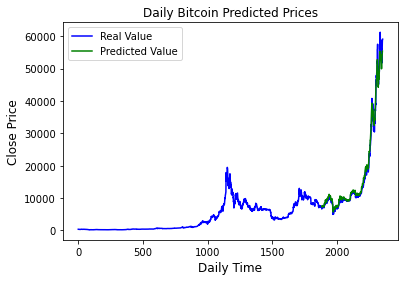

In [13]:
# Three parts of datasets are concatenated
final = np.append(trainPredict, validationPredict)
final = np.append(final, testPredict)
final = pd.DataFrame(data=final, columns=['Close'])
actual = dataset.Close
actual = actual.values
actual = pd.DataFrame(data=actual, columns=['Close'])

# Finally result are visualized
pyplot.plot(actual.Close, 'b', label='Real Value')
pyplot.plot(final.Close[1884:len(final)], 'g' , label='Predicted Value')
pyplot.title("Daily Bitcoin Predicted Prices")
pyplot.xlabel('Daily Time', fontsize=12)
pyplot.ylabel('Close Price', fontsize=12)
pyplot.legend(loc='best')
pyplot.show()